In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                              voting='hard')

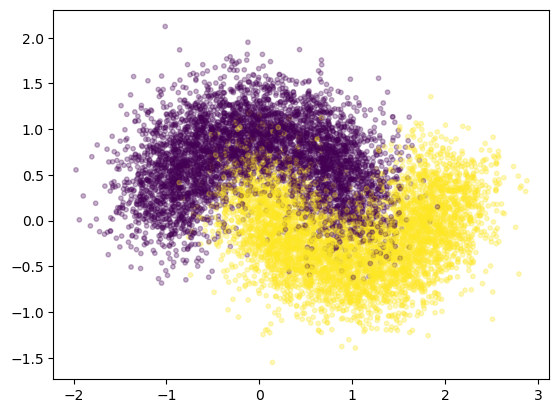

In [3]:
X,y = make_moons(n_samples=10000, noise=0.3)

plt.scatter(X[:,0], X[:,1], s=10, alpha=0.3,c=y)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [5]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    print(clf.__class__.__name__,':', accuracy_score(y_test,prediction))

LogisticRegression : 0.8715
RandomForestClassifier : 0.909
SVC : 0.9205
VotingClassifier : 0.915


In [7]:
#Bagging is short for bootstrap and aggregating which is taking from the training set a number of samples with replacement, Pasting is the same but without replacement, if you want pasting, just set bootstrap = False
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train,y_train)
prediction = bag_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test,prediction))

accuracy: 0.919


In [8]:

#using the out of bag instances (those instances that were not selected in an estimator) one can assess the evaluation score without necessarily separating the set in train and test
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            bootstrap=True, 
                            oob_score=True,
                            max_samples=100,
                            n_jobs=-1)
bag_clf.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True)

In [9]:
oob_score = bag_clf.oob_score_
y_pred = bag_clf.predict(X_test)
print('accuracy_score:', accuracy_score(y_test,y_pred), 'oob score:', oob_score)

accuracy_score: 0.9195 oob score: 0.914625


In [10]:
#AdaBoost is an ensemble method where the weight of the instances are updated after each predictor, i.e., more weight is given to unclassified instances
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

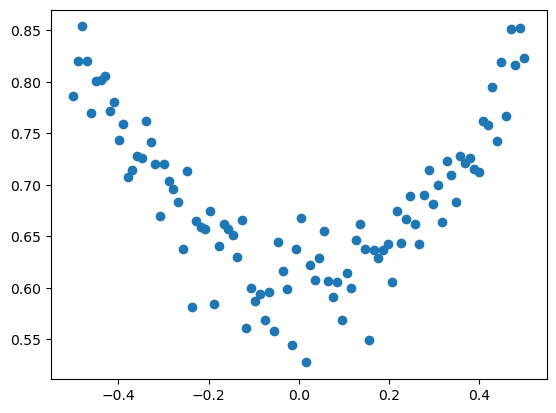

In [11]:
#Gradient Boosting is similar to AdaBoost but instead of updating the instances weights the following predictors are trained with the residual error of the previous predictor
import numpy as np

X = np.linspace(-0.5,0.5,100)
X2 = X**2
y = X**2 + 0.6 + 0.03*np.random.randn(100) 
plt.scatter(X,y)

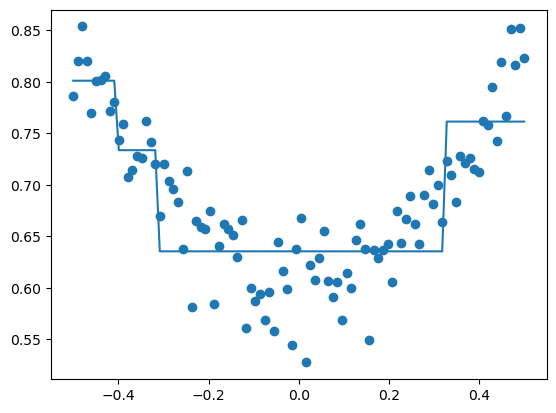

In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X.reshape(-1,1),y)
plt.plot(X,tree_reg.predict(X.reshape(-1,1)))
plt.scatter(X,y)

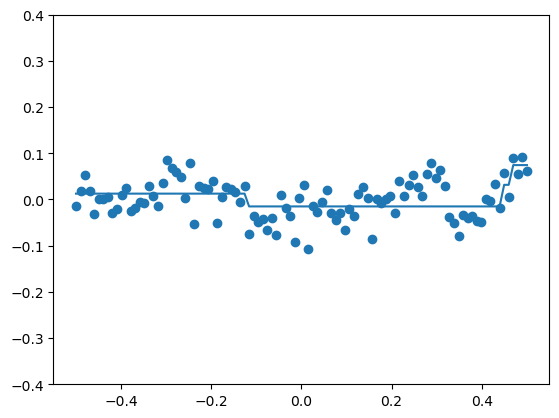

In [13]:
tree_reg2 = DecisionTreeRegressor(max_depth=2)
y_hat = tree_reg.predict(X.reshape(-1,1))

tree_reg2.fit(X.reshape(-1,1),y-y_hat)
plt.ylim(-0.4,0.4)
plt.plot(X,tree_reg2.predict(X.reshape(-1,1)))
plt.scatter(X,y-y_hat)

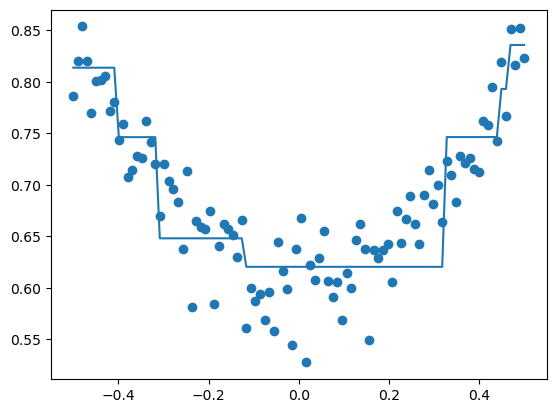

In [14]:
plt.scatter(X,y)
plt.plot(X,tree_reg.predict(X.reshape(-1,1))+tree_reg2.predict(X.reshape(-1,1)))

In [15]:
tree_reg3 = DecisionTreeRegressor(max_depth=2)
y_hat2 = tree_reg2.predict(X.reshape(-1,1))

tree_reg3.fit(X.reshape(-1,1),y-y_hat-y_hat2)

DecisionTreeRegressor(max_depth=2)

In [16]:
y_pred = sum(tree.predict(X.reshape(-1,1)) for tree in (tree_reg, tree_reg2, tree_reg3))

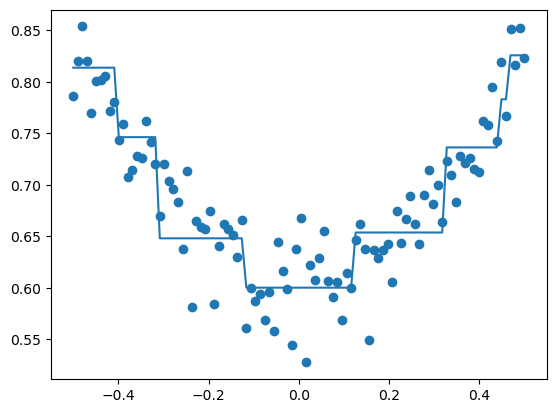

In [17]:
plt.scatter(X,y)
plt.plot(X,y_pred)

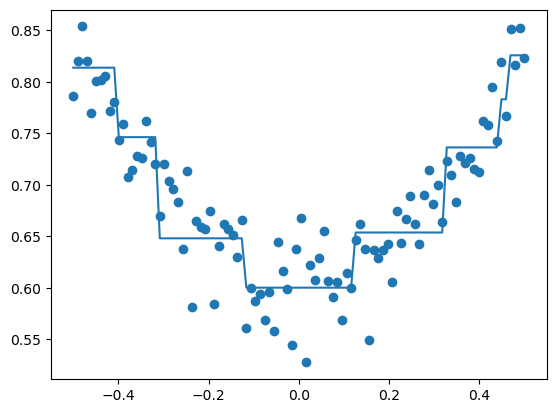

In [18]:
#Equivalently one could use the Gradient Boost Regressor (which uses trees) from scikit
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3, learning_rate=1)
gbrt.fit(X.reshape(-1,1),y)

plt.plot(X,gbrt.predict(X.reshape(-1,1)))
plt.scatter(X,y)

In [19]:
#The best number of estimators can be evaluated with early stopping such as

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val = train_test_split(X,y)
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)
gbrt.fit(X_train.reshape(-1,1),y_train)
error = [mean_squared_error(y_val,y_pred) for y_pred in gbrt.staged_predict(X_val.reshape(-1,1))]
best_n_estimators = np.argmin(error)+1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=best_n_estimators)
gbrt_best.fit(X_train.reshape(-1,1),y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=25)

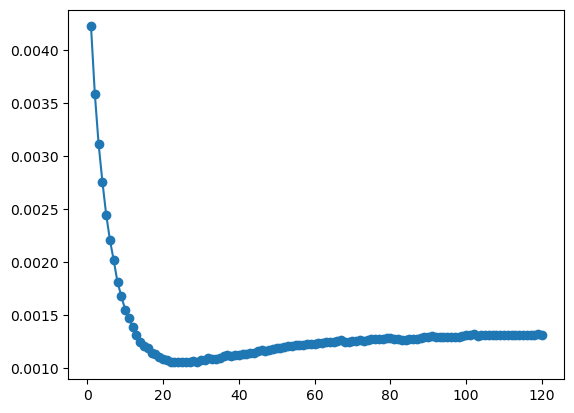

In [20]:
plt.plot(np.arange(1,120+1),error, 'o-') #the minimum squared error is at 51 trees

In [21]:
#this is an implementation to apply early stopping without actually computing the whole ensemble with n_estimators (it stops earlier if an optimal solution is found in the process)

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

error = float("inf")
counter = 0

for n_estimators in range(1,120+1):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train.reshape(-1,1),y_train)
    y_pred = gbrt.predict(X_val.reshape(-1,1))
    error2 = mean_squared_error(y_val,y_pred)
    if error2 <= error:
        error = error2
        counter = 0
    elif error2 > error:
        counter += 1
        if counter == 5:
            break

In [22]:
#an optimized implementation of gradient boosting is available through the Python library XGBoost
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train.reshape(-1,1),y_train)
xgb_reg.predict(X_val.reshape(-1,1))

array([0.70870566, 0.8021668 , 0.5520814 , 0.76735157, 0.8511342 ,
       0.64404774, 0.6451581 , 0.6851273 , 0.59344286, 0.72595596,
       0.6578168 , 0.75819224, 0.7098069 , 0.85248804, 0.65065646,
       0.6813937 , 0.60894   , 0.6402758 , 0.7155638 , 0.6629322 ,
       0.67211455, 0.6578168 , 0.7002414 , 0.85248804, 0.6289938 ],
      dtype=float32)

In [23]:
#xgboost already implements early stopping in a simple way

xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)

xgb_reg.fit(X_train.reshape(-1,1),y_train,
            eval_set=[(X_val.reshape(-1,1),y_val)])
xgb_reg.n_estimators

[0]	validation_0-rmse:0.15819
[1]	validation_0-rmse:0.11966
[2]	validation_0-rmse:0.09070
[3]	validation_0-rmse:0.07058
[4]	validation_0-rmse:0.05712
[5]	validation_0-rmse:0.04834
[6]	validation_0-rmse:0.04283
[7]	validation_0-rmse:0.03929
[8]	validation_0-rmse:0.03698
[9]	validation_0-rmse:0.03603
[10]	validation_0-rmse:0.03571
[11]	validation_0-rmse:0.03553
[12]	validation_0-rmse:0.03559
[13]	validation_0-rmse:0.03565


100

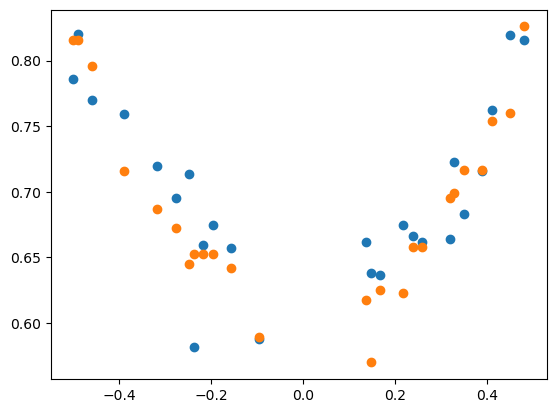

In [27]:
plt.scatter(X_val,y_val)
plt.scatter(X_val, xgb_reg.predict(X_val.reshape(-1,1)))